# 📋 **Student Information**

*Complete the required fields below with your personal and W&B account details.*

In [ ]:
FIRST_NAME = "Alireza" # replace with your first name
LAST_NAME = "Nobakht" # replace with your last name
STUDENT_ID = ... # replace with your student id
WANDB_ID = "alireza9" # replace with your wandb username
PROJECT_NAME = f"{FIRST_NAME}-{LAST_NAME}-DQN-EXPLORE-HW"
print(f"Project name: {PROJECT_NAME}")

In [ ]:
print(f"Check my results at https://wandb.ai/{WANDB_ID}/{PROJECT_NAME}")

In [ ]:
# Set DEBUG to True if you are still implementing the code and debugging
# and don't want to make your wandb dashboard messy.
# set DEBUG to False if you are almost done with the implementation
# and want check performance and compare hyperparameters and models
DEBUG = False

# 📘 Guidelines

> ⚠️ **Please read this section carefully before proceeding.**

### 🔧 Install Dependencies

In [ ]:
!apt install build-essential python3-dev
!git clone https://github.com/DeepRLCourse/Homework-10.git
%pip install swig
%pip install "Homework-10/BootstrapDQN"

### 📊 Weights & Biases (W&B) Integration

Follow these steps to set up tracking with [Weights & Biases](https://wandb.ai/site/):

1. [Create a W&B account](https://wandb.ai/site/).
2. Set the `WANDB_ID` variable in the **Student Information** section to your W&B username.
3. Create a new project using the name defined in the `PROJECT_NAME` variable. Ensure the project visibility is set to **Public**.
4. [Retrieve your W&B API key](https://docs.wandb.ai/support/find_api_key/).
5. Set the `WANDB_API_KEY`:
   - As a **secret** if you're using **Google Colab** or **Kaggle**
   - As an **environment variable** if running locally

#### 💻 Platform-Specific Setup

##### Google Colab


> You only need to add the secret — no code changes are required.

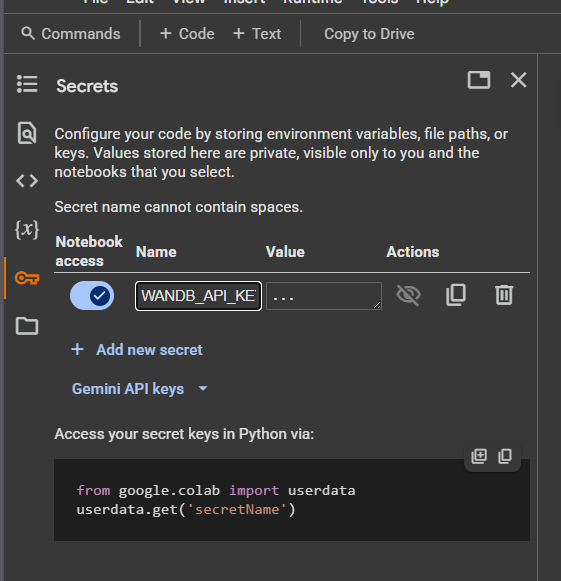

#### Kaggle

To configure W&B API key in Kaggle:

- Go to: `Add-ons` → `Secrets` → `Add Secret`
- **Label:** `WANDB_API_KEY`  
- **Value:** `<your_api_key>`

> You only need to add the secret — no code changes are required.

#### Local

You can set the `WANDB_API_KEY` as an environment variable manually or,

store it in a `.env` file:
```bash
# secrets.env
WANDB_API_KEY=your_api_key
```
and then run the following cell:

In [ ]:
from bootstrapdqn import get_machine
if get_machine() == "Local Machine":
    import dotenv
    dotenv.load_dotenv(".workspace/secrets.env") # give it the path to your secrets.env file

### 📤 Submission Requirements

In addition to submitting this notebook on **Quera**, you must:

- Have a W&B project matching the name in `PROJECT_NAME`, under the account defined by `WANDB_ID`
- Ensure the W&B link displayed in the **Student Information** section is valid
- Tag your final experiment run for **each algorithm** with `Final`:
  - Go to **Runs** (left sidebar) → **Tags** → Add the tag `Final`
  - A total of **four** runs should be tagged as `Final`

⚠️ **Important:** The `save_code` option must remain enabled. If a `Final` run does not include saved code, it will **not** be graded.

### 🧮 Grading Criteria

The score for each algorithm is provided in its respective section. This score is then multiplied by the environment score:
- `CartPole`: × 0.1
    - Minimum requirement: over 200 points across 5 consecutive evaluations
- `LunarLander`: × 0.7
    - Minimum requirement: over 200 points across 5 consecutive evaluations
- `MountainCar`: × 1.0
    - Minimum requirement: reach the goal state across 5 consecutive evaluations
- `FrozenLake`: × 1.2
    - Minimum requirement: reach the goal state across at least 5 evaluations of 15 consecutive evaluations
- `SeaQuest`: × 1.5
    -  Minimum requirement: over 2000 points across 5 consecutive evaluations

Total Score is 100. you can get up to 80 bonus score (180)

### 📝 Implementation Guide

- Implement the algorithms as subclasses of `BaseDQNAgent` provided in [`base_agent.py`](https://github.com/DeepRLCourse/Homework-10/blob/main/BootstrapDQN/src/bootstrapdqn/base_agent.py). You may add or override methods/properties as needed.
    - The `BaseDQNAgent` code will be automatically downloaded and imported. Ensure you review it carefully before implementing your algorithms.
- Code blocks or lines marked with `# DO NOT CHANGE` must remain unaltered in your final submission. You may modify them during development for debugging purposes, but revert them before submitting.
- If running locally, real-time W&B logging might face restrictions. Use W&B's offline mode for experiments and sync them later using the `wandb sync` command ([link](https://docs.wandb.ai/support/run_wandb_offline/)).
- Prioritize vector operations over loops for better performance. While algorithm descriptions might use loops for clarity, only the main training and rollout loops (implemented in `BaseDQNAgent`) should remain iterative. Failure to vectorize may significantly increase convergence time.
- For potentially more stable and faster training, you may consider using *Smooth L1 Loss* instead of Mean Squared Error. (Optional)
- Weight initialization significantly impacts performance. Orthogonal initialization is generally recommended in the RL community and might be worth trying.


### 💡 Tips & More

The following resource provides general advice for implementing and debugging RL algorithms (not required for this homework, but highly recommended):

- [Debugging RL, Without the Agonizing Pain](https://andyljones.com/posts/rl-debugging.html)

# 🧭 Exploration Techniques in DQN

## 🚀 Initialization


In [ ]:
# DO NOT CHANGE THIS BLOCK
from bootstrapdqn import ReplayBuffer, BaseDQNAgent, get_machine, set_wandb_key_form_secrets, envs
import torch
from torch import nn
import wandb
import random
import gymnasium as gym
import ale_py

gym.register_envs(ale_py)

In [ ]:
# DO NOT CHANGE THIS BLOCK
TA = True if WANDB_ID == "alireza9" else False
SAVE_CODE = False if TA else True

In [ ]:
# DO NOT CHANGE THIS BLOCK
# IF YOU CHANGE ANYTHING ABOUT ENVIRONMENTS AND THEIR RUN CONFIGS, YOUR CODE WILL NOT BE GRADED
from pprint import pprint
ENVS = envs()
pprint(ENVS)

In [ ]:
if not DEBUG:
    set_wandb_key_form_secrets()

## 💻 Algorithms Implementation

### Epsilon Greedy DQN

Consider the following implementation as a reference for implementing other algorithms.

You can also use it as a baseline for comparing the performance of subsequent algorithms.

In [ ]:
class EpsGreedyDQNAgent(BaseDQNAgent):
    """
    Epsilon-greedy DQN agent.
    """

    def __init__(self, epsilon: float = 0.1, eps_decay: float = 0.999, eps_min: float = 0.01, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.eps_min = eps_min

    def _decay_eps(self):
        """
        Decay the epsilon value.
        """
        self.epsilon = max(self.epsilon * self.eps_decay, self.eps_min)

    def _create_replay_buffer(self, max_size=1000000):
        self.replay_buffer = ReplayBuffer(
            [
                ("state", (self.env.observation_space.shape[0],), torch.float32),
                ("action", (), torch.int64),
                ("reward", (), torch.float32),
                ("next_state", (self.env.observation_space.shape[0],), torch.float32),
                ("done", (), torch.float32),
            ],
            max_size=max_size,
            device=self.device,
        )

    def _create_network(self):
        self.q_network = nn.Sequential(
            nn.Linear(self.env.observation_space.shape[0], 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, self.env.action_space.n),
        ).to(self.device)
        self.q_network.apply(
            lambda m: torch.nn.init.orthogonal_(m.weight, gain=torch.nn.init.calculate_gain("relu"))
            if isinstance(m, nn.Linear)
            else None
        )
        self.target_network = nn.Sequential(
            nn.Linear(self.env.observation_space.shape[0], 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, self.env.action_space.n),
        ).to(self.device)

    def _compute_loss(self, batch):
        """
        Compute the loss for the DQN agent.
        """
        states = batch["state"]
        actions = batch["action"]
        rewards = batch["reward"]
        next_states = batch["next_state"]
        dones = batch["done"]

        q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()
        next_q_values = self.target_network(next_states).max(1)[0]
        expected_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        loss = nn.SmoothL1Loss()(q_values, expected_q_values)
        return loss

    def _act_in_training(self, state):
        """
        Select an action during training.
        """
        self._decay_eps()
        if torch.rand(1).item() < self.epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                q_values = self.q_network(torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device))
                return q_values.argmax().item()

    def _act_in_eval(self, state):
        """
        Select an action during evaluation.
        """
        with torch.no_grad():
            q_values = self.q_network(torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device))
            return q_values.argmax().item()

    def _wandb_train_step_dict(self):
        log_dict = super()._wandb_train_step_dict()
        log_dict["train_step/epsilon"] = self.epsilon
        return log_dict

    def _save_dict(self):
        save_dict = super()._save_dict()
        save_dict["epsilon"] = self.epsilon
        save_dict["eps_decay"] = self.eps_decay
        save_dict["eps_min"] = self.eps_min
        return save_dict


### Bootstrap DQN

> Paper: [Deep Exploration via Bootstrapped DQN](https://arxiv.org/abs/1602.04621)

**40 Points**

#### Details

In this algorithm, instead of using a single network, we maintain an ensemble of networks (or a single network with multiple heads). At the start of each training episode, we randomly select one of these networks (heads) and use it to choose actions for the entire episode. This strategy approximates Thompson Sampling for the K-armed Bandit problem, enabling deeper exploration by leveraging the diversity among the ensemble members.

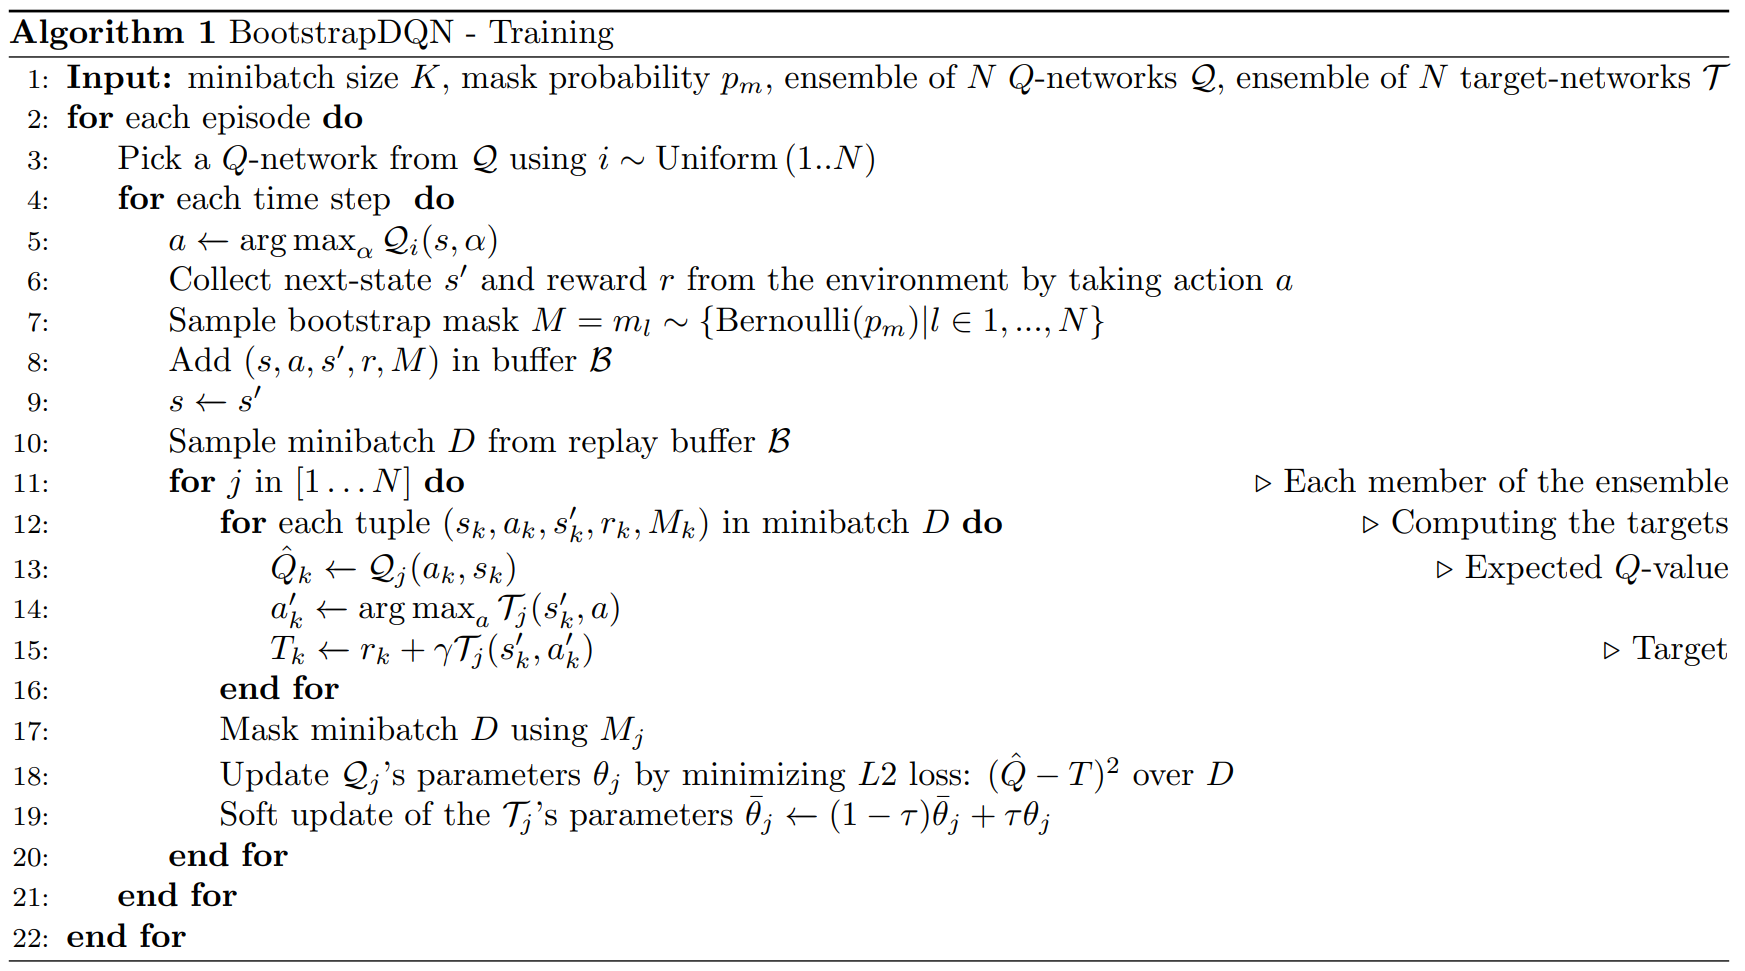

#### Implementation

In [ ]:
class MultiHeadQNet(nn.Module):
    ...


class BootstrapDQNAgent(EpsGreedyDQNAgent):
    """
    Bootstrap DQN agent.
    """

    # Recommended methods to implement/override:

    def __init__(self, k: int = 10, bernoulli_p: float = 0.5, **kwargs):
        self.k = k
        super().__init__(**kwargs)
        self.bernoulli_p = bernoulli_p
        # you may initialize the Bernoulli distribution
        # you may initialize the current head
        ...

    def _create_network(self):
        ...

    def _create_replay_buffer(self, max_size=1000000):
        # You may want to add masks to the replay buffer
        ...

    def _preprocess_add(self, state, action, reward, next_state, done):
        # You may generate masks here
        ...

    def _compute_loss(self, batch):
        ...

    def _episode(self):
        super()._episode()
        # You may want to sample the current head here
        ...

    def _act_in_training(self, state):
        self._decay_eps()
        ...

    def _act_in_eval(self, state):
        ...

    def _wandb_train_episode_dict(self):
        log_dict = super()._wandb_train_episode_dict()
        # you may want to add some additional information to the log_dict
        ...

    def _save_dict(self):
        save_dict = super()._save_dict()
        save_dict["k"] = self.k
        save_dict["bernoulli_p"] = self.bernoulli_p
        # you may want to add some additional information to the save_dict
        ...


### Bootstrap DQN with Randomized Prior Function

> Paper: [Randomized Prior Functions for Deep Reinforcement Learning](https://arxiv.org/abs/1806.03335)

**25 Points**

#### Details

This method is very similar to Bootstrap DQN, but introduces additional **non-trainable** networks (with multiple heads) called random priors. These priors are added to the Q-network outputs to encourage diversity among ensemble members, both across states and over time. During training, the Q-networks learn to compensate for the effect of these fixed random priors, which helps maintain exploration.

##### Notes
- Random prior networks are typically smaller (narrower and shallower) than the main Q-networks, so the Q-networks tend to distill their influence during training.
- There is a $\delta_\mathrm{RPF}$ coefficient to control the strength of the random priors, but for simplicity, you can set $\delta_\mathrm{RPF}=1$ and omit tuning this hyperparameter.

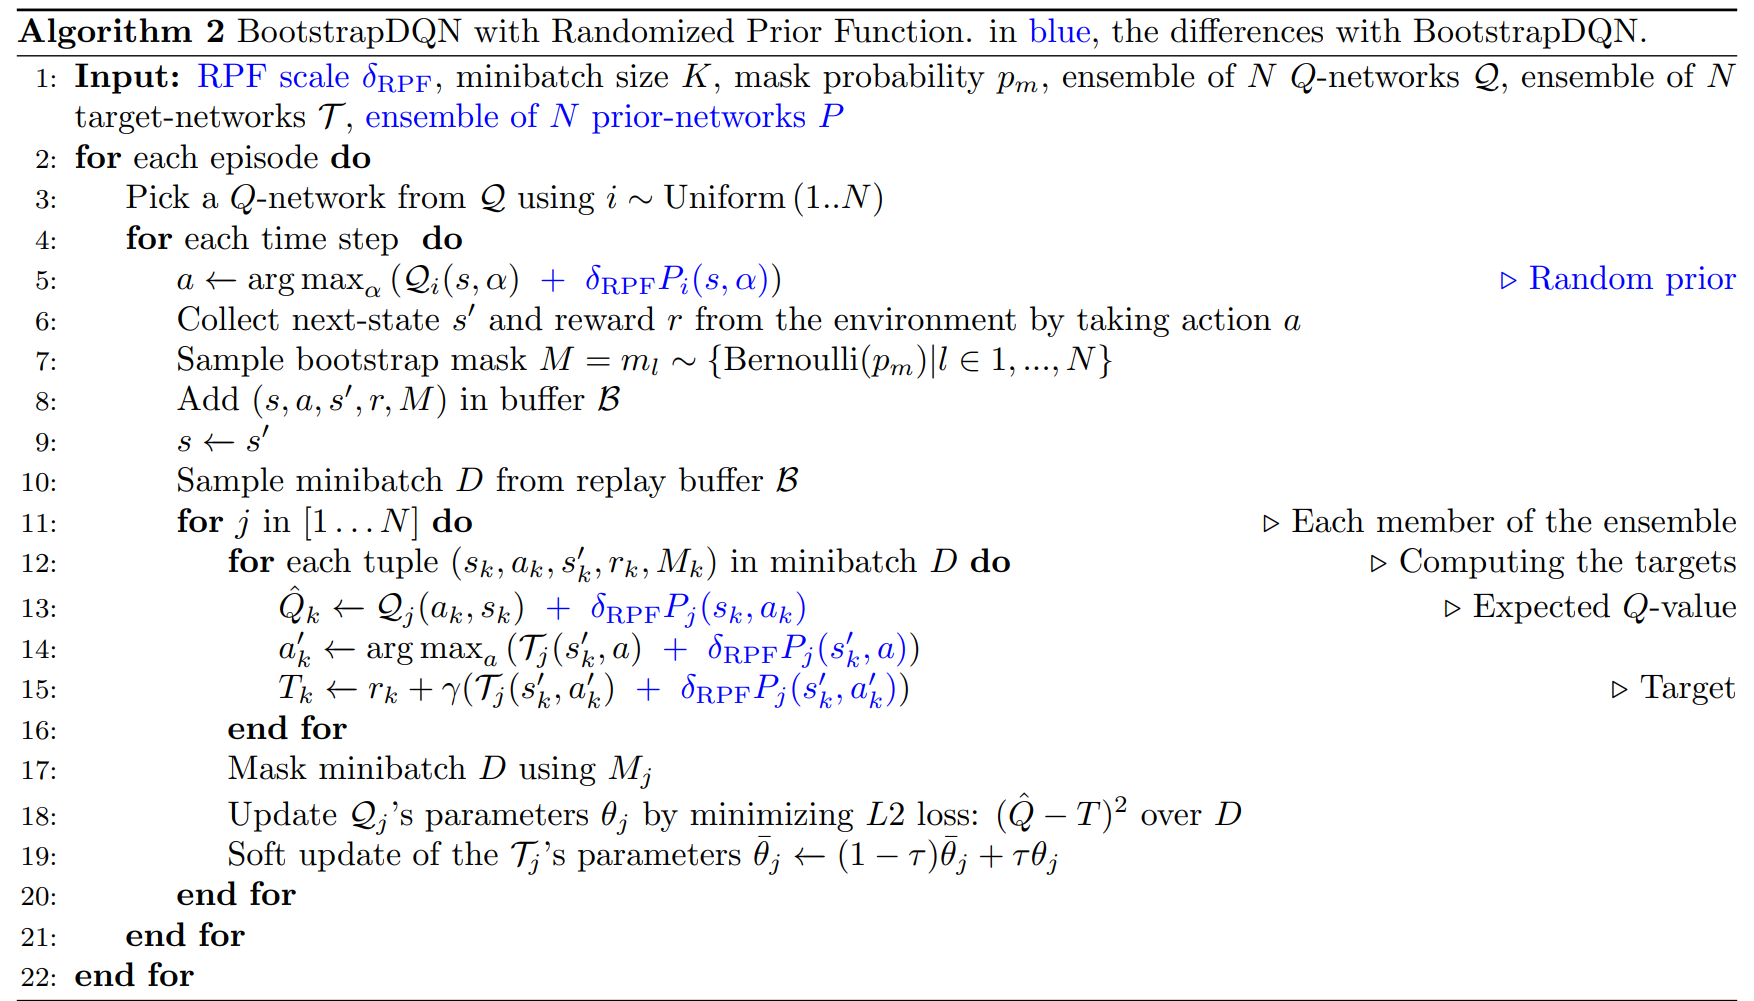

#### Implementation

In [ ]:
class PriorMultiHeadQNet(MultiHeadQNet): # inheriting from MultiHeadQNet is optional
    # you may want to create shallower neural net for the prior network
    ...


class RPFBootstrapDQNAgent(BootstrapDQNAgent):

    # Recommended methods to implement/override:

    def _create_network(self):
        super()._create_network()
        # you may want to create the prior network here
        ...

    def _act_in_training(self, state):
        self._decay_eps()
        ...

    def _act_in_eval(self, state):
        ...

    def _compute_loss(self, batch):
        ...


### Uncertainty Estimation for Sample Efficient RPF Bootstrap DQN

> Paper: [Sample Efficient Deep Reinforcement Learning via Uncertainty Estimation](https://arxiv.org/abs/2201.01666)

**35 Points**

#### Details

This method does not explicitly address the exploration problem but focuses on improving sample efficiency.

By maintaining an ensemble of Q-networks, multiple Q-values can be computed for each state-action pair. This enables the estimation of uncertainty in the target values. Using this uncertainty, a weighted loss is calculated, where the weights are inversely proportional to the uncertainty. The more confident we are about a target, the higher its weight during the update.

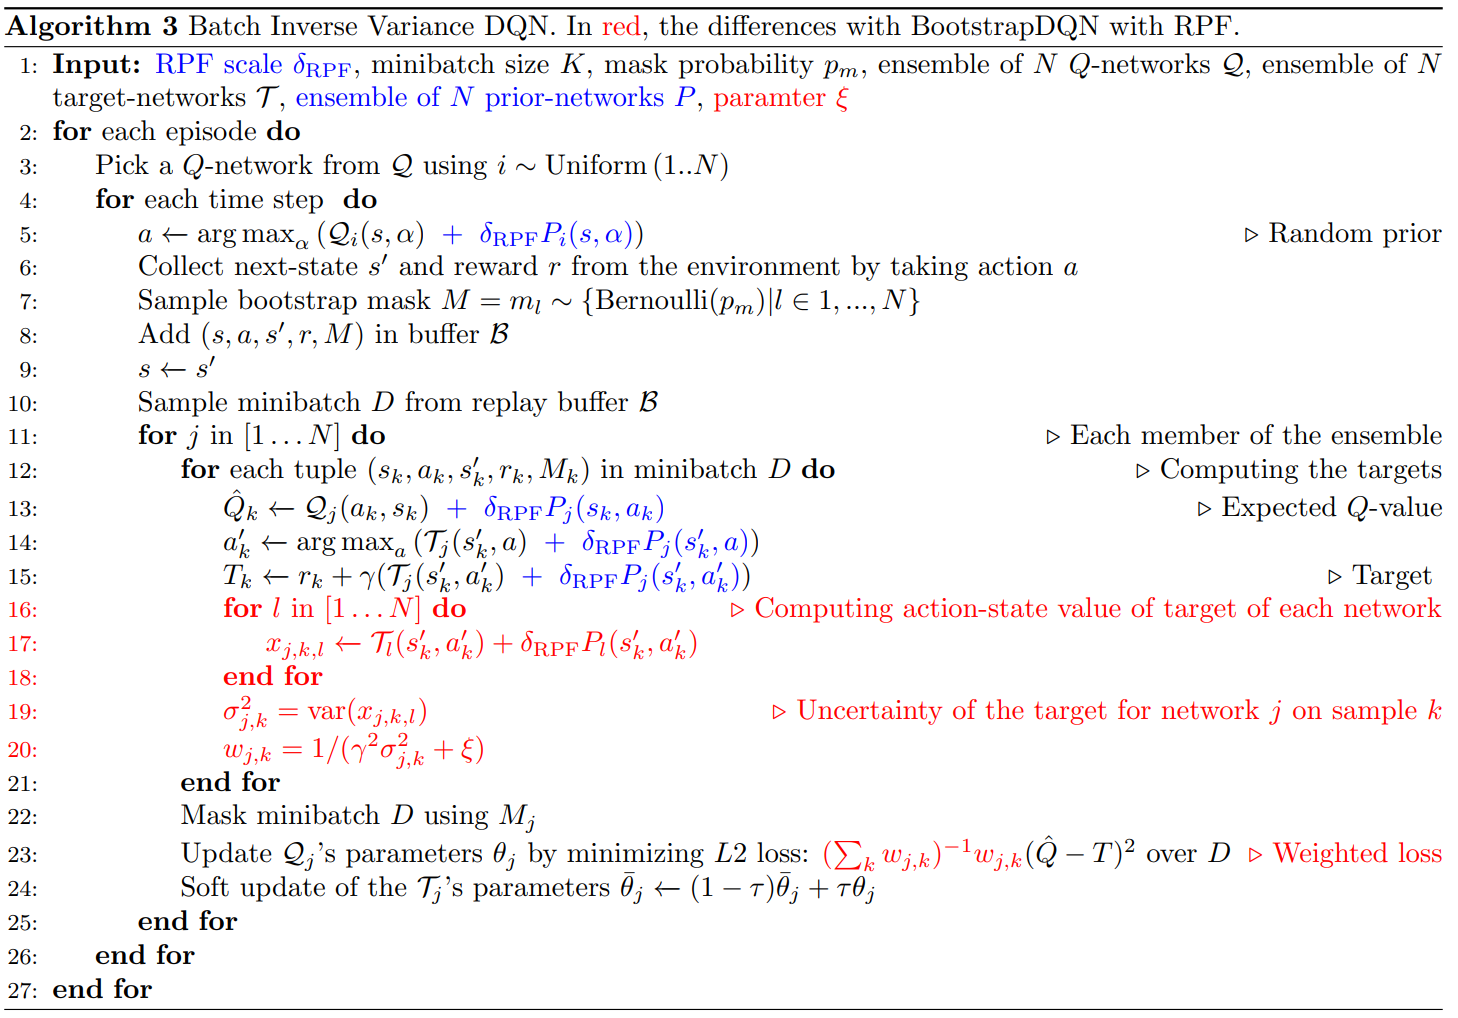

Logging Effective Batch Size (EBS) helps you to tune $\xi$ parameter:

$$
EBS = \dfrac{\left(\sum^K_k w_k\right)^2}{\sum_k^K w_k^2} = \dfrac{\left(\sum_k^K \dfrac{1}{(\sigma_k^2 + \xi)}\right)^2}{\sum_k^K\dfrac{1}{(\sigma_k^2 + \xi)^2}} 
$$

#### Bonus

1. Use the minimum Effective Batch Size (EBS) as a hyperparameter instead of $\xi$, and numerically calculate $\xi$ during each training step based on the minimum EBS. (5 points)
2. Implement the complete IV-DQN algorithm as described in the appendix of the original paper. (15 points)

#### Implementation

In [ ]:
class UEBootstrapDQNAgent(RPFBootstrapDQNAgent):

    # Recommended methods to implement/override:

    def __init__(self, xi: float = 0.5, **kwargs):
        super().__init__(**kwargs)
        self.xi = xi
        ...

    def _compute_loss(self, batch):
        ...

    def _save_dict(self):
        save_dict = super()._save_dict()
        save_dict["xi"] = self.xi
        ...

    def _wandb_train_step_dict(self):
        log_dict = super()._wandb_train_step_dict()
        # you may want to add some additional information to the log_dict
        # EBS is recommended
        ...


## ⚙️ Configs

Feel free to change hyperparameters

In [ ]:
env = ["FrozenLake", "CartPole", "MountainCar", "SeaQuest", "LunarLander"][3]
print(f"{env} is selected.")

base_agent_config = {
    **ENVS[env]["env"],
    "default_batch_size": 128,
    "gamma": 0.99,
    "learning_rate": 3e-4,
    "replay_buffer_capacity":100_000,
    "tau": 5e-3,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "gradient_norm_clip": 10.0,
    "start_training_after": 1000,
    "normalize_rewards": False,
    "scale_rewards": None
}

base_run_config = {
    **ENVS[env]["run"],
    "learn_every": 1,  # Apply learning every n steps of rollout
    "eval_every": 10_000,  # Evaluate model approximately every n steps
}

In [ ]:
eps_greedy_config = {
    **base_agent_config,
    "eps_decay": 0.9999,
    "eps_min": 0.01,
    "epsilon": 1.0,
}

In [ ]:
bootstrap_dqn_config = {
    **eps_greedy_config,
    "k": ...,
    "bernoulli_p": ...,
}

In [ ]:
rpf_bootstrap_dqn_config = {
    **bootstrap_dqn_config,
}

In [ ]:
ue_bootstrap_dqn_config = {
    **rpf_bootstrap_dqn_config,
    "xi": ...,
}

## 🔄 Training

The `try-except` block allows you to terminate the current algorithm's run directly from the W&B panel and proceed to the next algorithm without crashing the entire notebook. This can be particularly useful when using Kaggle's *Save Version* feature.

### Epsilon Greedy DQN

In [ ]:
# DON'T CHANGE THIS BLOCK
wandb_config = {
    "project": PROJECT_NAME,
    "name": "eps_greedy",
    "config": {**eps_greedy_config, **base_run_config, "machine": get_machine()},
    "save_code": SAVE_CODE,
    "tags": ["dqn", "eps_greedy"],
}

if DEBUG:
    wandb_run = None
else:
    wandb_run = wandb.init(**wandb_config)

eps_greedy_dqn_agent = EpsGreedyDQNAgent(wandb_run=wandb_run, **eps_greedy_config)

In [ ]:
# DON'T CHANGE THIS BLOCK
try:
    eps_greedy_dqn_agent.train(**base_run_config)
    wandb_run.finish()
except KeyboardInterrupt:
    pass

### Bootstrap DQN

In [ ]:
# DON'T CHANGE THIS BLOCK
wandb_config = {
    "project": PROJECT_NAME,
    "name": "bootstrap",
    "save_code": SAVE_CODE,
    "tags": ["dqn", "bootstrap"],
}

wandb_config["config"] = {} if TA else {**bootstrap_dqn_config, **base_run_config, "machine": get_machine()}

if DEBUG:
    wandb_run = None
else:
    wandb_run = wandb.init(**wandb_config)

bootstrap_dqn_agent = BootstrapDQNAgent(wandb_run=wandb_run, **bootstrap_dqn_config)

In [ ]:
# DON'T CHANGE THIS BLOCK
try:
    bootstrap_dqn_agent.train(**base_run_config)
    wandb_run.finish()
except KeyboardInterrupt:
    pass

### Bootstrap DQN with Randomized Prior Function

In [ ]:
# DON'T CHANGE THIS BLOCK
wandb_config = {
    "project": PROJECT_NAME,
    "name": "randomized_prior",
    "save_code": SAVE_CODE,
    "tags": ["dqn", "rpf_bootstrap"],
}

wandb_config["config"] = {} if TA else {**rpf_bootstrap_dqn_config, **base_run_config, "machine": get_machine()}

if DEBUG:
    wandb_run = None
else:
    wandb_run = wandb.init(**wandb_config)

rpf_bootstrap_dqn_agent = RPFBootstrapDQNAgent(wandb_run=wandb_run, **rpf_bootstrap_dqn_config)

In [ ]:
# DON'T CHANGE THIS BLOCK
try:
    rpf_bootstrap_dqn_agent.train(**base_run_config)
    wandb_run.finish()
except KeyboardInterrupt:
    pass

### Uncertainty Estimation for Sample Efficient RPF Bootstrap DQN

In [ ]:
# DON'T CHANGE THIS BLOCK
wandb_config = {
    "project": PROJECT_NAME,
    "name": "uncertainty_estimation",
    "save_code": SAVE_CODE,
    "tags": ["dqn", "ue_bootstrap"],
}

wandb_config["config"] = {} if TA else {**ue_bootstrap_dqn_config, **base_run_config, "machine": get_machine()}

if DEBUG:
    wandb_run = None
else:
    wandb_run = wandb.init(**wandb_config)

ue_bootstrap_dqn_agent = UEBootstrapDQNAgent(wandb_run=wandb_run, **ue_bootstrap_dqn_config)

In [ ]:
# DON'T CHANGE THIS BLOCK
ue_bootstrap_dqn_agent.train(**base_run_config)
wandb_run.finish()